In [1]:
import matplotlib.pyplot as plt
import tree_utils as tu
from tqdm import tqdm
import networkx as nx
import numpy as np
import random
from sklearn.preprocessing import normalize

"""
Wilson's Alg:
- Randomly pick a sink
- take a lerw towards the sink
- remember the tree
- keep doing until done
"""

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


"\nWilson's Alg:\n- Randomly pick a sink\n- take a lerw towards the sink\n- remember the tree\n- keep doing until done\n"

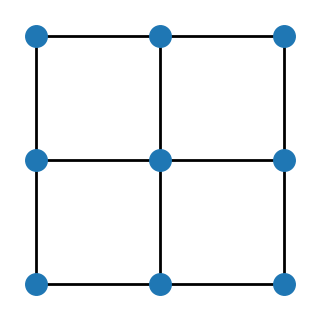

In [2]:
def reverse_dict(d):
    new_dict = dict()
    for k, v in d.items():
        new_dict[v] = k
    return new_dict

dims = (3, 3)
g = tu.generate_grid_graph(dims, queen=False)

# relabel nodes for ease later
labels = {node: (dims[0] * node[0]) + node[1] + 1 for node in g.nodes}
g = nx.relabel_nodes(g, labels, copy=False)
node_map = reverse_dict(labels)

tu.draw(g, node_map=node_map)

In [96]:
def wilsons(g):
    root = randomly_pick_root(g)
#     print("Root: ", root)
    tree = nx.Graph()
    tree.add_node(root)
    
    while tree.number_of_nodes() < g.number_of_nodes():
        add_branch(g, tree, root)
#         print("Added branch to tree, current tree: ", tree.edges)
        
#     print("Done with tree")
#     print()
    return tree

def randomly_pick_root(g):
    return random.choice(list(g.nodes))

def pick_leaf(g, tree):
    candidates = list(set(g.nodes()) - set(tree.nodes()))
    return random.choice(candidates)

def erase_singletons(branch):
    # remove the singletons after erasing the loop
    to_remove = []
    for node in branch.nodes:
        if len(list(branch.neighbors(node))) == 0:
            to_remove.append(node)
    for node in to_remove:
        branch.remove_node(node)
            
def erase_loop_if_exists(branch, g):
    try:
        cycle = nx.find_cycle(branch)
        
#         print("Cycle found! ", cycle)
        for (u, v) in cycle:
            branch.remove_edge(u, v)
        erase_singletons(branch)
        
    except nx.exception.NetworkXNoCycle:
        pass


def add_branch(g, tree, root):
    leaf = pick_leaf(g, tree)
    curr = leaf
    branch = nx.Graph()
    reached_root = False
    
    while reached_root is False:
        nxt = random.choice(list(g.neighbors(curr)))
        
#         print("Adding edge: ", (curr, nxt))
        if branch.has_edge(curr, nxt):
#             print("Small cycle found!")
            branch.remove_edge(curr, nxt)
            erase_singletons(branch)
            curr = nxt
            continue
            
        
        branch.add_edge(curr, nxt)
        erase_loop_if_exists(branch, g)
#         print("Current branch:", branch.edges)
        curr = nxt

        if nxt in tree.nodes():
            reached_root = True
            
    tree = tree.update(branch.edges, branch.nodes)

In [99]:
def test_valid_tree(tree, g):
    assert(len(list(nx.connected_components(tree))) == 1)
    assert(len(tree.edges) == len(g.nodes)-1)

for i in range(1000):
    tree = wilsons(g)
    test_valid_tree(tree, g)
# tu.draw(tree, node_map=node_map)

In [75]:
len(list(nx.connected_components(tree)))

2

In [76]:
list(nx.connected_components(tree))

[{1, 4, 5, 7, 8, 9}, {2, 3, 6}]

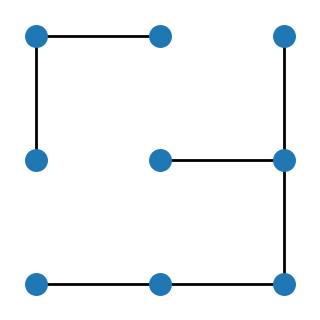

In [78]:
tu.draw(tree, node_map=node_map)